In [19]:
import torch
import torch.nn as nn
import torch.optim as opt
from model.sffnet import USFFNet
from utils.evaluate import Evaluate

from torch.utils.data import DataLoader, TensorDataset
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./logs')
from torchvision import utils as vutils
import os
import random
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [29]:
device = 'cuda:0'
batch_size = 128
stride = 1
window_size = 150

path = './datasets/SOC/0degC'
train_list = ['589_Mixed1.csv', '589_Mixed2.csv', '590_Mixed4.csv', '590_Mixed5.csv', '590_Mixed6.csv', '590_Mixed7.csv']
test_list = ['590_Mixed8.csv']

In [30]:
from utils.build_dataloader import get_dataloder
train_loader, test_loader = get_dataloder(path, window_size, stride, train_list, test_list, batch_size, device)

loading data...


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


In [31]:
test_ratio = 1
epoches = 20
weight_decay = 1e-4
learning_rate = 5e-4
loss_funcation = nn.MSELoss()
evaluater = Evaluate(path.split('/')[1], 'Ablation', test_ratio)
block_num = 5
feature_num = 3

spa_ks_list = [3, 5, 7, 7, 7]
fre_ks_list = [3, 5, 7, 7, 7]
fus_ks_list = [3, 3, 7, 7, 7]
mid_channel_list = [32, 16, 8, 4, 4]


In [32]:
import torch
import math
import torch.nn.init as init
import torch.nn as nn
import torch.fft as fft
from model.uncertainty_head import UncertaintyHead
from model.basic_module import *
from Embed import *
from torchvision import utils as vutils
import time


class SpatialFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(SpatialFlow, self).__init__()
        padding = int(kernel_size//2)
        self.up_conv1 = nn.Conv1d(feature_num  ,feature_num*2,kernel_size,1,padding)
        self.up_conv2 = nn.Conv1d(feature_num*2,feature_num*4,kernel_size,1,padding)

        self.c_conv = nn.Conv1d(feature_num*4, feature_num*4,kernel_size,1,padding)

        self.down_conv2 = nn.Conv1d(feature_num*4,feature_num*2,kernel_size,1,padding)
        self.down_conv1 = nn.Conv1d(feature_num*2,feature_num  ,kernel_size,1,padding)
        # self.icb = ICB(feature_num,mid_channel)
        # up_sampling

        # down_sampling

        self.Spa_CNN = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding),
                                      nn.ReLU(),
                                      nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding),
                                      )
        self.act = nn.ReLU()


    def forward(self, x):
        Spa_feature = self.Spa_CNN(x)

        return Spa_feature


class FrequencyFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(FrequencyFlow, self).__init__()
        padding = int(kernel_size//2)
        self.pha_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))
        self.amp_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))

    def make_complex(self, phase, amplitude):
        real = amplitude * torch.cos(phase)
        im = amplitude * torch.sin(phase)
        complex_num = torch.complex(real, im)
        return complex_num

    def forward(self, x):
        frequency = fft.fft(x, dim=2, norm='backward')
        phase = torch.angle(frequency)
        magnitude = torch.abs(frequency)
        refine_phase = self.pha_process(phase)
        refine_magnitude = self.amp_process(magnitude)
        refine_spatial = self.make_complex(refine_phase, refine_magnitude)
        Fre_feature = torch.abs(fft.ifft(refine_spatial, dim=2, norm='backward'))
        return Fre_feature


class FusionBlock(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(FusionBlock, self).__init__()
        self.SA = SpatialAttention(kernel_size)
        self.CA = ChannelAttention(feature_num, r)


    def forward(self, fre_feature, spa_feature):
        spatial_refine_feature = self.SA(fre_feature - spa_feature)
        channel_refine_feature = self.CA(fre_feature + spa_feature)
        return channel_refine_feature + spatial_refine_feature

class ICB(nn.Module):
    def __init__(self, in_features, hidden_features, drop=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(in_features, hidden_features, 1)
        self.conv2 = nn.Conv1d(in_features, hidden_features, 3, 1, padding=1)
        self.conv3 = nn.Conv1d(hidden_features, in_features, 1)
        self.drop = nn.Dropout(drop)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_features)

    def forward(self, x):
        # x = x.transpose(1, 2)
        x1 = self.conv1(x)
        x1_1 = self.act(x1)
        x1_2 = self.drop(x1_1)

        x2 = self.conv2(x)
        x2_1 = self.act(x2)
        x2_2 = self.drop(x2_1)

        out1 = x1 * x2_2
        out2 = x2 * x1_2

        out = self.conv3(out1 + out2)

        return out




class CRU(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(CRU, self).__init__()
        self.vc_channel = 2
        self.t_channel = 1
        ratio = 2
        self.vc_conv1   = nn.Conv1d(self.vc_channel,self.vc_channel*ratio,kernel_size)
        self.t_conv1 = nn.Conv1d(self.t_channel,self.t_channel*ratio,kernel_size)

        self.vc_conv2 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,1)
        self.t_conv2 = nn.Conv1d(self.t_channel*ratio,self.t_channel,1)

        self.vc_conv3 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,kernel_size)
        self.t_conv3 = nn.Conv1d(self.t_channel*ratio,self.t_channel,kernel_size)

    def forward(self, x):
        vc,t = torch.split(x,[self.vc_channel,self.t_channel],dim=1)
        vc = self.vc_conv(vc)
        t  = self.t_conv(t)

        vc = self.vc_conv2(vc) + self.vc_conv3(vc)
        t = self.t_conv2(t) + self.vc_conv3(t)

        feature = torch.cat([vc,t],dim=1)

        return feature + x

class PAIFILTER(nn.Module):

    def __init__(self,hidden_size,seq_len):
        super(PAIFILTER, self).__init__()
        self.seq_len = seq_len
        self.pred_len = 1
        self.scale = 0.02

        self.embed_size = self.seq_len
        self.hidden_size = hidden_size

        self.w = nn.Parameter(self.scale * torch.randn(3, self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pred_len)
        )
        self.softmx = nn.Softmax(dim=1)


    def circular_convolution(self, x, w):
        x = torch.fft.rfft(x, dim=2, norm='ortho')
        w = torch.fft.rfft(w, dim=1, norm='ortho')
        y = x * w
        out = torch.fft.irfft(y, n=self.embed_size, dim=2, norm="ortho")
        return out

    def forward(self, x):
        x = self.circular_convolution(x, self.w.to(x.device))  # B, N, D
        x = self.fc(x)
        x = self.softmx(x)

        return x


class SFFBlock(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, spa_ks, fre_ks, fus_ks, r, fb, sf, ff):
        super(SFFBlock, self).__init__()
        self.fb, self.sf, self.ff = fb, sf, ff
        if fb is True:
            self.FB = FusionBlock(window_size, fus_ks, feature_num, r)
        if sf is True:
            self.SF = SpatialFlow(window_size, feature_num, mid_channel, spa_ks)
        if ff is True:
            self.FF = FrequencyFlow(window_size, feature_num, mid_channel, fre_ks)

        self.ffn = nn.Linear(feature_num*2,feature_num)
        self.act = nn.Sigmoid()

    def forward(self, x):

        if self.sf is True:
            Spa_feature = self.SF(x)
        if self.ff is True:
            Fre_feature = self.FF(x)
        if self.fb is True:
            # feature = Spa_feature
            # feature = Fre_feature
            feature = Fre_feature + Spa_feature
            # feature = self.ffn(torch.concat([Spa_feature , Fre_feature],dim=1).transpose(2,1)).transpose(1,2)
            # feature = self.FB(Spa_feature,Fre_feature)
            # feature = self.icb(torch.concat([Spa_feature , Fre_feature],dim=1))

        return feature+x


class USFFNet(nn.Module):

    def __init__(self, num_block, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list):
        super(USFFNet, self).__init__()
        self.SFFBlock = nn.Sequential()
        for i in range(num_block):
             self.SFFBlock.add_module('SFFBlock'+str(i), SFFBlock(window_size, feature_num, mid_channel_list[i], spa_ks_list[i], fre_ks_list[i], fus_ks_list[i], 2, True, True, True))
        self.CNNI = nn.Sequential(nn.Conv1d(feature_num, 1, 3, 1, 1))
        self.Uncertainty_Head = UncertaintyHead(window_size,stride)
        # self.icb = ICB(feature_num, feature_num)
        self.embedding = DataEmbedding(feature_num,feature_num)

        self.paifilter = PAIFILTER(hidden_size=50,seq_len=window_size)

    def forward(self, x):

        embeded_x = self.embedding(x)
        # print(feature.shape)
        # feature, weight  = self.Adaptive_Spectral_Block(embeded_x)
        # print(feature.shape,sum(freq_mask))
        # print(feature.shape)

        weight = self.paifilter(embeded_x)

        # feature = self.SFFBlock(feature + x )
        feature = self.SFFBlock(weight * embeded_x + x)
        # feature = self.CNNI(feature)
        # feature = self.icb(feature)
        #

        feature = feature.reshape(feature.shape[0], feature.shape[1]*feature.shape[2])

        gamma, nu, alpha, beta = self.Uncertainty_Head.forward(feature)
        return gamma, nu, alpha, beta




In [33]:
model = USFFNet(block_num, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list).to(device)

optimizer = opt.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
evaluater.record_param_setting(window_size, stride, batch_size, learning_rate, weight_decay, model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)


In [34]:
lambda_coef = []
train_loss = []
vaild_loss = []

In [35]:
for epoch in range(epoches):
    model.train()
    epoch_loss = 0
    print('epoch: '+str(epoch))
    for x, y in tqdm(train_loader):
        # train
        gamma, nu, alpha, beta = model.forward(x)
        loss, nig_loss, nig_regularization = model.Uncertainty_Head.get_loss(y, gamma, nu, alpha, beta)

        loss = loss_funcation(gamma, y)+loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.Uncertainty_Head.hyperparams_update(nig_regularization)
        # print(gamma.shape)
        _loss = loss_funcation(gamma, y)
        epoch_loss += _loss.item()

    epoch_loss /= train_loader.__len__()
#     writer.add_scalar("Loss/train",epoch_loss,epoch)
    lambda_coef.append(model.Uncertainty_Head.lambda_coef.detach().cpu().numpy())
    train_loss.append(epoch_loss)
    print('trainning_loss = '+str(epoch_loss))
    if epoch%test_ratio == 0:
        model.eval()
        epoch_loss = 0
        for x, y in test_loader:
            gamma, nu, alpha, beta = model.forward(x)
            gamma = torch.cat((gamma[:5], (gamma[:-5] + gamma[1:-4]  + gamma[2:-3] + gamma[3:-2] + gamma[4:-1]) / 5), dim=0)
            _loss = loss_funcation(gamma, y)
            epoch_loss += _loss.item()
        epoch_loss /= test_loader.__len__()
#         writer.add_scalar('Loss/vali',epoch_loss,epoch)

        vaild_loss.append(epoch_loss)
        print('testing_loss = '+str(epoch_loss))

    # if early_stopping.early_stop:
    #     print("Early stopping")
    #    break
    evaluater.visualize(train_loss, vaild_loss, model, None)

epoch: 0


100%|██████████| 2810/2810 [00:56<00:00, 49.76it/s]


trainning_loss = 0.005158497572166421
testing_loss = 0.0012941646670867613
Validation loss decreased (1.000000 --> 0.001294).  Saving model ...
epoch: 1


100%|██████████| 2810/2810 [00:43<00:00, 64.97it/s]


trainning_loss = 0.0011723459084075792
testing_loss = 0.0008302031100722682
Validation loss decreased (0.001294 --> 0.000830).  Saving model ...
epoch: 2


100%|██████████| 2810/2810 [00:42<00:00, 65.95it/s]


trainning_loss = 0.0009378617370995822
testing_loss = 0.001000696165229275
epoch: 3


100%|██████████| 2810/2810 [00:44<00:00, 63.84it/s]


trainning_loss = 0.0008013228321049422
testing_loss = 0.0011677244495010254
epoch: 4


100%|██████████| 2810/2810 [00:45<00:00, 61.41it/s]


trainning_loss = 0.0007264020775479606
testing_loss = 0.0009098361322899376
epoch: 5


100%|██████████| 2810/2810 [00:44<00:00, 63.34it/s]


trainning_loss = 0.0006681398827573483
testing_loss = 0.0012433175744900262
epoch: 6


100%|██████████| 2810/2810 [00:43<00:00, 64.81it/s]


trainning_loss = 0.0006249223893766832
testing_loss = 0.0007052867220154975
Validation loss decreased (0.000830 --> 0.000705).  Saving model ...
epoch: 7


100%|██████████| 2810/2810 [00:40<00:00, 68.72it/s]


trainning_loss = 0.0006357580324236363
testing_loss = 0.0007417396827570562
epoch: 8


100%|██████████| 2810/2810 [00:41<00:00, 67.91it/s]


trainning_loss = 0.0006184041833594521
testing_loss = 0.0005888686645212882
Validation loss decreased (0.000705 --> 0.000589).  Saving model ...
epoch: 9


100%|██████████| 2810/2810 [00:45<00:00, 61.73it/s]


trainning_loss = 0.0005420960168485957
testing_loss = 0.0008106136029201641
epoch: 10


100%|██████████| 2810/2810 [00:44<00:00, 62.49it/s]


trainning_loss = 0.0005107182220061181
testing_loss = 0.0005218219044548157
Validation loss decreased (0.000589 --> 0.000522).  Saving model ...
epoch: 11


100%|██████████| 2810/2810 [00:40<00:00, 68.98it/s]


trainning_loss = 0.0004838209189835014
testing_loss = 0.0005029071769998235
Validation loss decreased (0.000522 --> 0.000503).  Saving model ...
epoch: 12


100%|██████████| 2810/2810 [00:40<00:00, 69.13it/s]


trainning_loss = 0.00046854266429007603
testing_loss = 0.0006394457041732066
epoch: 13


100%|██████████| 2810/2810 [00:40<00:00, 69.35it/s]


trainning_loss = 0.0004463490251121542
testing_loss = 0.0005524493424719795
epoch: 14


100%|██████████| 2810/2810 [00:46<00:00, 60.84it/s]


trainning_loss = 0.0004300446754615187
testing_loss = 0.0006063213435848023
epoch: 15


100%|██████████| 2810/2810 [00:47<00:00, 59.05it/s]


trainning_loss = 0.0004186914642384935
testing_loss = 0.0006631119693719591
epoch: 16


100%|██████████| 2810/2810 [00:41<00:00, 67.05it/s]


trainning_loss = 0.0004050490344369956
testing_loss = 0.0006525701096958367
epoch: 17


100%|██████████| 2810/2810 [00:42<00:00, 66.36it/s]


trainning_loss = 0.00039278092402409684
testing_loss = 0.0006960904967807919
epoch: 18


100%|██████████| 2810/2810 [00:40<00:00, 68.89it/s]


trainning_loss = 0.0003848076635257845
testing_loss = 0.0005395825551831275
epoch: 19


100%|██████████| 2810/2810 [00:47<00:00, 59.47it/s]


trainning_loss = 0.00038230520682106976
testing_loss = 0.0005025840295089398
Validation loss decreased (0.000503 --> 0.000503).  Saving model ...


<Figure size 640x480 with 0 Axes>

In [36]:
exp_path = 'result/datasets/Ablation/exp16'
model = torch.load(os.path.join(exp_path, 'model.pkl')).to(device)

In [37]:
from utils.metrics import *
import matplotlib.pyplot as plt
def Test(test_dataloder, model, path, data_type):
    # Testing
    MAE = []
    MSE = []
    y_true = np.array([1])
    y_hat =  np.array([1])
    upper_bound_list = np.array([1])
    lower_bound_list = np.array([1])
    for x, y in tqdm(test_dataloder):
        gamma, nu, alpha, beta = model.forward(x)
        gamma = torch.cat((gamma[:5], (gamma[:-5] + gamma[1:-4]  + gamma[2:-3] + gamma[3:-2] + gamma[4:-1]) / 5), dim=0)
        MAE.append(getMAE(gamma, y))
        MSE.append(getMSE(gamma, y))
        alpha = alpha.squeeze(dim=-1).squeeze(dim=-1).detach().cpu().numpy().reshape(-1)
        beta = beta.squeeze(dim=-1).squeeze(dim=-1).detach().cpu().numpy().reshape(-1)
        gamma = gamma.squeeze(dim=-1).squeeze(dim=-1).detach().cpu().numpy().reshape(-1)
        var = np.sqrt(np.abs(beta/((alpha - 1))))
        upper_bound = gamma + 1.96*var
        lower_bound = gamma - 1.96*var
        y = y.squeeze(dim=-1).squeeze(dim=-1).detach().cpu().numpy().reshape(-1)
        y_hat = np.concatenate((y_hat, gamma))
        y_true = np.concatenate((y_true, y))
        upper_bound_list = np.concatenate((upper_bound_list, upper_bound))
        lower_bound_list = np.concatenate((lower_bound_list, lower_bound))
    MAE = np.array(MAE).mean()
    RMSE = np.sqrt(np.array(MSE).mean())
    y_hat = np.array(y_hat)
    record = pd.DataFrame(np.transpose(np.array([y_hat, y_true, lower_bound_list, upper_bound_list]), [1, 0]))
    record.columns = ['y_hat', 'y_true', 'lower_bound_list', 'upper_bound_list']
    record.to_excel(path+'/'+'result.xlsx')
    plt.grid()
    plt.plot(np.arange(len(y_hat)), y_hat, 'g', linewidth=0.1)
    plt.plot(np.arange(len(y_true)), y_true, 'r', linewidth=0.5)
    plt.fill_between(np.arange(len(y_hat)), lower_bound_list, upper_bound_list, facecolor='blue', alpha=0.5)
    plt.title(data_type)
    plt.xlabel('time step')
    plt.ylabel('SOC')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
    plt.savefig(path+'/'+data_type+'.jpg', dpi=300)
    plt.clf()
    return MAE, RMSE

100%|██████████| 544/544 [00:03<00:00, 137.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


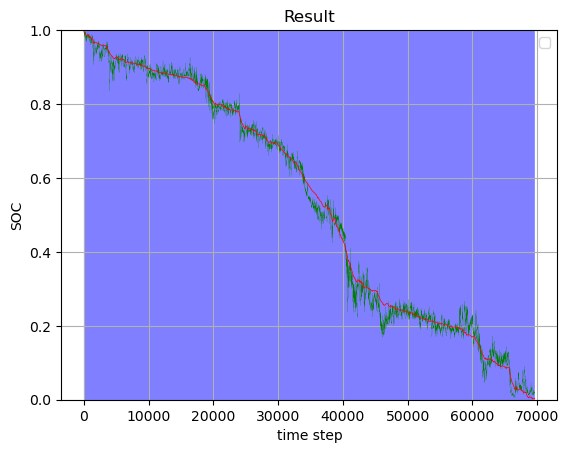

0.016637994 0.022418385


<Figure size 640x480 with 0 Axes>

In [38]:
exp_path = 'result/'+'datasets/'+'Ablation/exp13'
MAE, RMSE = Test(test_loader, model, exp_path, 'Result')
print(MAE,RMSE)